In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from typing import List

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Tokenization

### 简介
Tokenization 的主要目的是将文本分解成更小的单位 (Tokens)，减小模型输入数据的内在结构复杂度 (从句子变为单词序列)，从而简化模型训练的难度。同时将字符的序列转化为 Token 序号的序列，便于模型输入。

Tokenization 首先确定语言的词表划分粒度，一般可分为：
* 字符级：将文本分解为字符。
* 单词级：将文本分解为单词。
* 子词级：将单词进一步分解为更小的有意义单元（如前缀、后缀）。

之后使用预定义的规则来识别 tokens, 或使用统计或机器学习技术来识别最优的 token 切分方式。例如，BPE（Byte Pair Encoding）或 SentencePiece。

最后实现一组文本序列和 Tokens 序列之间相互转化的函数，即可完成 Tokenization 部分。

### 实验要求

1. 实现字符级切分的简单 tokenizer， 由 字符表， 字符到 token 的 encoder () 函数 和 token 到字符的 decoder () 函数组成。
2. 调用 现有的 tokenizer 实现，比如 openai 的 tiktoken

In [2]:
class Tokenizer:
    def __init__(self, dataPath: str):
        with open(dataPath, "r", encoding="utf-8") as f:
            self.dataset = f.read()
        self.generate_vocabulary()

    def generate_vocabulary(
        self,
    ) -> None:
        # FIXME:
        # Create a sorted list of unique characters
        unique_chars = sorted(set(self.dataset))
        # Create a dictionary to map each character to a unique index
        self.char2index = {char: idx + 1 for idx, char in enumerate(unique_chars)}
        self.char2index["<START>"] = 0  # Adding start token
        self.char2index["<END>"] = len(self.char2index)  # Adding end token
        # Create a dictionary to map each index back to its character
        self.index2char = {idx: char for char, idx in self.char2index.items()}


    def encode(
        self,
        sentence: str,
    ) -> torch.Tensor:
        """
        # FIXME:
        例子, 假设 A-Z 对应的 token 是 1-26, 句子开始，结束符号的 token 是 0。
        input  : "ABCD"
        output : Tensor([0,1,2,3])

        注意: 为了后续实验方便，输出 Tensor的 数据类型 dtype 为 torch.long。
        """
        # Encode the sentence to a list of indices
        tokens = [self.char2index["<START>"]] + [self.char2index[char] for char in sentence] + [self.char2index["<END>"]]
        # Convert the list to a tensor of type torch.long
        return torch.tensor(tokens, dtype=torch.long)


    def decode(
        self,
        tokens: torch.Tensor,
    ) -> str:
        """
        # FIXME:
        例子, 假设 A-Z 对应的 token 是 1-26, 句子开始，结束符号的 token 是 0。
        input : Tensor([0,1,2,3])
        output : "ABCD"
        """
        # Decode the tensor of indices back to a string
        chars = [self.index2char[idx.item()] for idx in tokens if idx.item() in self.index2char]
        # Join the characters to form the decoded string
        return "".join(chars).replace("<START>", "").replace("<END>", "")

### 定义 dataloader 和 dataset

为了高效加载数据，我们需要把输入文件接入 PyTorch 的数据加载器中。在这里我们定义 `ShakespeareDataset` 类用于加载数据集，用 PyTorch 的 `DataLoader` 类来实现数据加载。


In [3]:
class ShakespeareDataset(Dataset):
    def __init__(self, filepath, tokenizer, chunk_size):
        self.tokenizer = tokenizer
        with open(filepath, "r", encoding="utf-8") as file:
            text = file.read()
        self.encoded = self.tokenizer.encode(text)
        self.chunk_size = chunk_size

    def __len__(self):
        return len(self.encoded) - self.chunk_size

    def __getitem__(self, idx):
        # FIXME:提取一段文本(长度为 chunk_size）作为输入，以及这段文本的每一个字符的下一个字符作为标签
        # example(not correspond to real text): chunk = tensor([ 0, 20, 49, 58, 59])
        #         label = tensor([20, 49, 58, 59, 19])
        # decoded chunk: "The "
        # decoded label: "he T"
        chunk = self.encoded[idx:idx + self.chunk_size]
        label = self.encoded[idx + 1:idx + self.chunk_size + 1]
        return chunk, label


tokenizer = Tokenizer(dataPath="input.txt")


def create_dataloader(filepath, tokenizer, chunk_size, batch_size, shuffle=True):
    dataset = ShakespeareDataset(filepath, tokenizer, chunk_size)
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)]
    )
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    return train_dataloader, val_dataloader

注意力的计算公式为：
$$
Head = Attention(x)=Softmax(M\cdot QK^T)V\\
Q=xW_{q},K=xW_{k}, V=xW_{v}
$$
这里实现的一些数学技巧可以参见 `attention.ipynb`

In [4]:
class HeadAttention(nn.Module):
    def __init__(self, seq_len: int, embed_size: int, hidden_size: int):
        super().__init__()
        # embed_size: dimension for input embedding vector
        # hidden_size: dimension for hidden vector. eg. x:(..., embed_size) --to_q--> query_vector:(..., hidden_size)

        # a triangular bool matrix for mask
        self.register_buffer("tril", torch.tril(torch.ones(seq_len, seq_len)))

        # FIXME:
        # Initialize three linear transformations for Q, K, and V
        self.to_q = nn.Linear(embed_size, hidden_size)
        self.to_k = nn.Linear(embed_size, hidden_size)
        self.to_v = nn.Linear(embed_size, hidden_size)


    def forward(self, inputs) -> torch.Tensor:
        # input: (batch_size, seq_len, embed_size)
        # return (batch_size, seq_len, hidden_size)

        # FIXME:
        batch_size, seq_len, embed_size = inputs.shape

        # Apply linear transformations to get Q, K, V
        Q = self.to_q(inputs)  # (batch_size, seq_len, hidden_size)
        K = self.to_k(inputs)  # (batch_size, seq_len, hidden_size)
        V = self.to_v(inputs)  # (batch_size, seq_len, hidden_size)

        # Calculate attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1))  # (batch_size, seq_len, seq_len)
        scores = scores / (embed_size ** 0.5)  # Scale scores

        # Apply mask
        mask = self.tril[:seq_len, :seq_len]  # Ensure mask has the same size as scores
        scores = scores.masked_fill(mask == 0, float('-inf'))

        # Apply softmax to get attention weights
        attn_weights = F.softmax(scores, dim=-1)  # (batch_size, seq_len, seq_len)

        # Multiply attention weights with V
        out = torch.matmul(attn_weights, V)  # (batch_size, seq_len, hidden_size)

        return out

Transformer 中使用的注意力机制时会使用多个注意力头，期望每个注意力头能够注意到不同的信息。
所以实际公式需要修改如下
$$
MultiHeadAttention(x)=[Head_0, Head_1,...,Head_h]W_o\\
Head_i = Attention(x)=Softmax(M\cdot Q_iK_i^T)V_i\\
Q_i=xW_{iq},K=xW_{ik}, V=xW_{iv}
$$
在搭建网络的过程中，同学们可能会用到 `nn.ModuleList` 这个库，每个 $Head_i$ 的计算可以直接使用上面已经实现的单头注意力计算。最后对于这些注意力头再使用一个简单的线性层/矩阵 $W_o$ 汇总信息即可。

In [5]:
class MultiHeadAttention(nn.Module):
    # MultiHeadAttention is consist of many HeadAttention output.
    # concat all this head attention output o_i, then merge them with a projection matrix W_o, as [o_1, o_2, ...] x W_o
    # The reason for using multi-head attention is that we want each head to be able to extract different features
    def __init__(self, n_heads: int, head_size: int, seq_len: int, embed_size: int):
        # n_heads is the number of head attention
        # head_size is the hidden_size in each HeadAttention
        super().__init__()

        # FIXME:
        # head_size = embed_size // n_heads

        # Ensure embed_size is divisible by n_heads
        assert embed_size % n_heads == 0, "embed_size must be divisible by n_heads"

        # Define the head size based on the number of heads and embedding size
        self.n_heads = n_heads
        self.head_size = head_size
        self.embed_size = embed_size

        # Create multiple HeadAttention modules and store them in a ModuleList
        self.heads = nn.ModuleList(
            [HeadAttention(seq_len, embed_size, head_size) for _ in range(n_heads)]
        )

        # Define the linear layer to combine the outputs from all heads
        self.linear = nn.Linear(n_heads * head_size, embed_size)

    def forward(self, inputs):
        # input: (batch_size, seq_len, embed_size), make sure embed_size=n_heads x head_size
        # return: (batch_size, seq_len, embed_size)

        # FIXME:
        # Apply each HeadAttention module to the inputs
        head_outputs = [head(inputs) for head in self.heads]  # List of (batch_size, seq_len, head_size)

        # Concatenate the outputs from each head along the last dimension
        concatenated = torch.cat(head_outputs, dim=-1)  # (batch_size, seq_len, n_heads * head_size)

        # Apply the linear layer to combine the heads' outputs
        output = self.linear(concatenated)  # (batch_size, seq_len, embed_size)

        return output

## 专家网络 Expert

Expert 即为标准 Transformer 中的 FeedForward 模块。

在经过 MultiHeadAttention 模块后，seq_len 中的每一个 Embedding 都对应了前文信息的加权求和。在经过 FeedForward 模块时，模型对每一个位置的 Embedding 进行了两次线性变换和一次非线性变换，可以视为对当前语境下的信息进行加工。知识编辑的一些研究表明，FeedForword 模块参数包含了大量的事实性知识。

一个直观的想法是，类比于 MultiHeadAttention，我们在每一层训练多个 FeedForward 模块，对于不同位置的 Embedding 使用不同的 FeedForward 模块处理对应的信息。就好像每层有多个 Expert, 每个 Expert 都负责处理一类数据的深加工，因此我们称 FeedForward 为 Expert。

实现方面:

FeedForward 层由两层简单的线性层组成，对于一个 (batch_size, seq_len, embed_size) 输入的向量 x
只在最后一个维度上进行计算，以实现词的特征维度上的交互 (注意力机制是词之间的交互)。
其首先用一个线性层将 x 最后一维扩大至原先 4 倍，然后继续用一个线性层还原回原先的维度。

In [6]:
class Expert(nn.Module):
    def __init__(self, embed_size: int):
        super().__init__()
        # FIXME:
        self.linear1 = nn.Linear(embed_size, 4 * embed_size)
        self.linear2 = nn.Linear(4 * embed_size, embed_size)
        self.activation = nn.ReLU()  # Use ReLU as the activation function

    def forward(self, inputs):
        # inputs: (batch_size, seq_len, embed_size)
        # -> mid: (batch_size, seq_len, 4 x embed_size)
        # -> outputs: (batch_size, seq_len, embed_size)
        # FIXME:
        # Apply the first linear transformation and activation
        mid = self.activation(self.linear1(inputs))  # (batch_size, seq_len, 4 * embed_size)
        # Apply the second linear transformation
        outputs = self.linear2(mid)  # (batch_size, seq_len, embed_size)
        return outputs

## 选通网络 TopkRouter

在实现了单个 Expert 后，我们要设计一个选通网络决策每个 Embedding 要使用那个 Expert 计算

### 为了说明选通网络的实现方式，我们定义一下记号：

inputs.shape = [batch_size, seq_len, embed_size] = [1, 8, 16]

即输入有 batch_size=1 个数据点，该数据有 seq_len 长度的 context，即包含 seq_len=8 个 Embedding，每个 Embedding 长度为 embed_dim=16。

记 num_expert=4, 即该层包含 num_expert 个并列的 Expert。

记 active_expert=2, 即计算每个 Embedding 仅有 active_expert 个 Expert 参与计算。

### 选通网络计算
对于有 seq_len=8 的数据，如果每个 Expert 都参与计算每一个 Embedding，那么一共需要计算 seq_len*embed_size=32 次， 这极大的增加了模型计算量，因此我们往往只激活其中的 active_experts 个 Expert，这要求我们对每一个 Embedding 计算最合适的 active_experts 个 Expert。

对于单个 Expert 的原版 Transformer 来说：

$$
outputs[0,seq] = FeedForward(inputs[0,seq])
$$

对于多个 Expert 的网络：

$$
outputs[0,seq] = \sum_{i \in range(num\_model)} \alpha_{i} Expert_{i}(inputs[0,seq])
$$

$$
\alpha_{i} = \left\{
\begin{array}{ll}
    1 & Expert_{i}  \text{is selected} \\
    0 & Expert_{i}  \text{is not selected} \\
\end{array}
\right.
$$
将 $\{\alpha_0,\alpha_1,\dots,\alpha_{num_experts-1}\}$ 记为向量 $\alpha$:
$$
outputs[0,seq] = \alpha \cdot \{Expert_i(inputs[0,seq])\}
$$

一个选通 0,2 号 Expert 的 $\alpha$ 的例子是 $[1,0,1,0]$

问题在于如何求得 $\alpha$, 对于一个 Embedding，我们使用神经网络对每个 Expert 打分，再根据分数计算 $\alpha$

$$
score[0,seq] = MLP(inputs[0,seq])  \\
\alpha = topK(score[0,seq])
$$

例如：

$$
score[0,seq] = [11.32,1.54,14.83,-1.90] \\
\alpha = [1,0,1,0]
$$

从优化的角度来说，$\alpha$ 取前 $k$ 大的分数的下标（即 argmax），这个操作是不可导的，这里我们用之前在 `attention.ipynb` 中提到的技巧处理这里的计算。

$$
mask(score[0,seq]) = [11.32,-inf,14.83,-inf] \\
\alpha = softmax(mask(score[0,seq])) = [0.028,0,0.971,0] \\
index = [1,0,1,0]
$$

我们用这个 $\alpha$ 和 $index$ 用做选通网络.

In [7]:
# First define the top k router module
class TopkRouter(nn.Module):
    def __init__(self, embed_size, num_experts, active_experts):
        ## FIXME:
        ## embed_size : dimension of embedding
        ## num_experts : how many Experts per layer
        ## active_experts: only active_experts out of num_experts are selected to process Embeddings per token.
        super().__init__()
        self.embed_size = embed_size
        self.num_experts = num_experts
        self.active_experts = active_experts

        # Define a linear layer to compute scores for each expert
        self.score_network = nn.Linear(embed_size, num_experts)

    def forward(self, inputs):
        ## FIXME:
        ## 完成这部分时，注意使用 Softmax() 对 router_output 做标准化。同时注意这部分所用操作的可导性。
        ## 输入值
        ## inputs is the output tensor from multihead self attention block, shape (B:batch size, T: seq_len, C: embed_size)
        ## 返回值
        ## router_output: normalized weight of Experts, 即教程中的 \alpha
        ## indices:   index of selected Experts, 即教程中的 index
        # Compute scores for each expert
        scores = self.score_network(inputs)  # (batch_size, seq_len, num_experts)

        # Get the top k scores and their indices
        topk_scores, topk_indices = torch.topk(scores, self.active_experts, dim=-1)

        # Create a mask with -inf for non-topk scores
        mask = torch.full_like(scores, float("-inf"))
        mask.scatter_(-1, topk_indices, topk_scores)

        # Apply softmax to the masked scores to get normalized weights
        router_output = F.softmax(mask, dim=-1)  # (batch_size, seq_len, num_experts)

        # Create binary indices for selected experts
        indices = torch.zeros_like(scores)
        indices.scatter_(-1, topk_indices, 1)
        return router_output, indices

## 稀疏专家网络 SparseMoE

![moe](./moeSparse.png)

在定义完 Expert 和 TopkRouter 后，我们可以定义 SparseMoE 模块。

在前向过程中，对于 inputs.shape=[Batch_size,seq_len,embed_size] 第二维度 seq_len 个 Embedding,我们先利用 TopkRouter 计算出选通专家序号 indices 以及专家权重 router_output。

我们将 Embedding 通过选通的 Expert 得出 active_expert 个新的 Embedding，然后使用 router_output 的作为权重对新的 Embedding 加权求和作为输出。


In [8]:
class SparseMoE(nn.Module):
    def __init__(self, embed_size: int, num_experts: int, active_experts: int):
        # FIXME:
        super().__init__()
        self.embed_size = embed_size
        self.num_experts = num_experts
        self.active_experts = active_experts

        # Initialize the TopkRouter
        self.router = TopkRouter(embed_size, num_experts, active_experts)

        # Initialize the Experts
        self.experts = nn.ModuleList([Expert(embed_size) for _ in range(num_experts)])

    def forward(self, inputs):
        # FIXME:
        # inputs: (batch_size, seq_len, embed_size)
        # Get the router outputs and indices of selected experts
        router_output, indices = self.router(inputs)  # (batch_size, seq_len, num_experts)
        # Initialize the final output tensor
        batch_size, seq_len, _ = inputs.shape
        final_output = torch.zeros(batch_size, seq_len, self.embed_size, device=inputs.device)

        # Iterate over the number of experts
        for i in range(self.num_experts):
            # Get the indices where the i-th expert is active
            mask = indices[..., i]  # (batch_size, seq_len)
            if mask.sum() > 0:
                # Extract the embeddings that will go through the i-th expert
                expert_inputs = inputs * mask.unsqueeze(-1)  # (batch_size, seq_len, embed_size)
                # Apply the i-th expert
                expert_output = self.experts[i](expert_inputs)  # (batch_size, seq_len, embed_size)
                # Weight the expert output with the router output and accumulate
                final_output += expert_output * router_output[..., i].unsqueeze(-1)

        return final_output

Transformer 由一层层的 block 堆叠而成，其中每个 block 的结构从模型的结构图展开中可以看到，由 LayerNorm，Masked multi head attention，(SparseMoE) FeedForward 组成。

对于一个表示句子的输入向量 x，其首先会经过 Layer Normalization 层。Layer Normalization 层对于一个句子个数 x 句子长度 x 单词向量维度的输入 x, 会在最后两维上进行规范化处理，起到稳定训练的作用。

$$
LN(x)=\frac{x-mean(x)}{\sqrt{var(x)+\epsilon}}\cdot\gamma+\beta
$$

其中 mean 和 var 都是在最后两个维度上进行的，layernorm 的实现同学们可以直接调用 nn.LayerNorm。经过 layernorm 层后，再经过 Mask multi head attention 层之后，会在 + 号处再次和原始的输入进行相加，这样的做法能够提高训练的稳定性。有兴趣的同学可以从梯度角度思考原因，或者搜索残差连接相关资料进行学习。之后再同样经过一层 layernorm 和 feedforwad 之后，就可以得到 block 块的输出了。即 x' = x+MHA(LN(x)), y = FFN(LN(x'))+x'。

In [9]:
class Block(nn.Module):
    # Transformer basic block, consist of MultiHeadAttention, FeedForward and layer normalization
    def __init__(
        self,
        embed_size: int,
        n_heads: int,
        seq_len: int,
        num_experts: int,
        active_experts: int,
    ):
        super().__init__()
        # FIXME: implement block structure
        self.layernorm1 = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(n_heads, embed_size // n_heads, seq_len, embed_size)
        self.layernorm2 = nn.LayerNorm(embed_size)
        self.feedforward = SparseMoE(embed_size, num_experts, active_experts)

    def forward(self, inputs):
        # input: (batch_size, seq_len, embed_size)
        # FIXME: forward with residual connection
        x = self.layernorm1(inputs)
        x = self.attention(x) + inputs
        y = self.layernorm2(x)
        output = self.feedforward(y) + x
        return output

In [10]:
class SparseMoETransformer(nn.Module):
    # Transformer decoder, consist of
    # token embedding layer and position_embedding(position_embedding 可以理解为对位置编码，感兴趣的同学可以查阅原文，这里可以看为vocab_len = seq_len的Embedding)
    # a stack of Transformer basic block
    # a layernorm and output linear layer
    def __init__(
        self,
        vocab_size: int,
        seq_len: int,
        embed_size: int,
        n_layers: int,
        n_heads: int,
        num_experts: int,
        active_experts: int,
    ):
        # vocab_size is the number of word in vocabulary dict
        # seq_len is the sequence length/sentence length
        # embed_size is the embedding vector dimension
        super().__init__()
        # FIXME:
        self.seq_len = seq_len
        self.token_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = nn.Embedding(seq_len, embed_size)
        self.blocks = nn.ModuleList([
            Block(embed_size, n_heads, seq_len, num_experts, active_experts) 
            for _ in range(n_layers)
        ])
        self.layernorm = nn.LayerNorm(embed_size)
        self.output_layer = nn.Linear(embed_size, vocab_size)

    def forward(self, inputs, labels=None):
        # labels: the (ground) true output
        # FIXME: implement the forward function of the transformer

        # inputs:(batch_size, seq_len, )
        batch_size, seq_len = inputs.shape
        # embedding:(batch_size, seq_len, embed_size)
        position_ids = torch.arange(seq_len, device=inputs.device).unsqueeze(0).expand(batch_size, -1)
        embeddings = self.token_embedding(inputs) + self.position_embedding(position_ids)
        # attens:(batch_size, seq_len, embed_size)
        x = embeddings
        for block in self.blocks:
            x = block(x)

        x = self.layernorm(x)
        # logits:(batch_size, seq_len, vocab_size)
        logits = self.output_layer(x)

        # compute the loss

        if labels is None:
            loss = None
        else:
            batch_size, seq_len, vocab_size = logits.shape
            logits = logits.view(batch_size * seq_len, vocab_size)
            labels = labels.view(batch_size * seq_len)
            loss = F.cross_entropy(logits, labels)
        return logits, loss

    def generate(self, inputs, max_new_tokens):
        inputs = torch.tensor(tokenizer.encode(inputs)).unsqueeze(0)
        device = next(self.parameters()).device
        inputs = inputs.to(device)
        if inputs.size(1) > self.seq_len:
            inputs = inputs[:, : self.seq_len]
        generated = inputs
        for _ in range(max_new_tokens):
            if generated.size(1) > self.seq_len:
                generated_input = generated[:, -self.seq_len :]
            else:
                generated_input = generated
            logits, _ = self.forward(generated_input)
            last_logits = logits[:, -1, :]
            next_token_ids = torch.argmax(last_logits, dim=-1)
            next_token_ids = next_token_ids.unsqueeze(-1)
            generated = torch.cat([generated, next_token_ids], dim=1)
        return generated

# 训练循环

如果你已经完成了模型定义等内容，训练的过程实际上在高度封装的 Pytorch 库中非常简单, 因为你并不需要写对应的反向传播。



#### Loss

Loss 用来**衡量**模型预测与真实值之间的**差距**。

常见的几个 Loss 函数：

* 交叉熵：$\text{CrossEntropy Loss} = -\sum_{i=1}^{n} y_i \log(\hat{y}_i)$
* 均方误差：$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y_i})^2$
* 绝对误差：$\text{MAE} = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y_i}|$

不同的 loss 对应不同的优化目标，如果写错 loss 函数会导致模型不收敛/性能很差。

#### 训练循环

当我们写好 Optimizer 和 Loss 之后，对应的训练循环就十分简单了。

我们只需要做以下事情：

* 从 dataloader 里面拿到一个 batch 的数据以及标签
* 将数据送入模型，进行前向传播
* 拿到模型输出的 logits
* 将 logits 和 标签进行 loss 计算
* 用 Optimizer
    * 清空梯度
    * 反向传播
    * 更新参数

In [11]:
from tqdm import tqdm


def train(model, dataloader, epoch, device):
    # Optimizer 会根据模型的输出和真实标签计算梯度，然后利用反向传播算法更新模型的参数。
    # 在本实验中你可以将 Optimizer 视作黑盒，只需要知道如何使用即可。
    # 找一个合适的 Optimizer。对不同的任务，模型，最适合的优化器是不一样的，你可以先尝试最常用的 Adam，如果有兴趣可以看看其他的优化器。
    # docs see: https://pytorch.org/docs/stable/optim.html
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # FIXME:
    model.train()
    total_loss = 0

    for i, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # FIXME: implement the training process, and compute the training loss and validation loss
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        logits, loss = model(inputs, labels=targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch} Loss: {total_loss / len(dataloader)}")
    return total_loss / len(dataloader)


def validate(model, dataloader, epoch, device):
    model.eval()
    # FIXME: 实现验证函数。与训练函数类似，但不需要计算梯度。
    total_loss = 0

    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            logits, loss = model(inputs, labels=targets)
            total_loss += loss.item()

    print(f"Epoch {epoch} Validation Loss: {total_loss / len(dataloader)}")
    return total_loss / len(dataloader)

100%|██████████| 1743/1743 [02:10<00:00, 13.38it/s]


Epoch 0 Loss: 1.7492950986461673


100%|██████████| 436/436 [00:11<00:00, 37.08it/s]


Epoch 0 Validation Loss: 1.416691155608641
Epoch 0 Train Loss: 1.7492950986461673, Valid Loss: 1.416691155608641


100%|██████████| 1743/1743 [02:10<00:00, 13.31it/s]


Epoch 1 Loss: 1.360903606836097


100%|██████████| 436/436 [00:11<00:00, 36.89it/s]


Epoch 1 Validation Loss: 1.3217352010788175
Epoch 1 Train Loss: 1.360903606836097, Valid Loss: 1.3217352010788175


100%|██████████| 1743/1743 [02:09<00:00, 13.47it/s]


Epoch 2 Loss: 1.2939875394670155


100%|██████████| 436/436 [00:11<00:00, 38.81it/s]


Epoch 2 Validation Loss: 1.2741222933891716
Epoch 2 Train Loss: 1.2939875394670155, Valid Loss: 1.2741222933891716


100%|██████████| 1743/1743 [02:09<00:00, 13.44it/s]


Epoch 3 Loss: 1.2517616570987582


100%|██████████| 436/436 [00:11<00:00, 38.85it/s]


Epoch 3 Validation Loss: 1.2385612581301173
Epoch 3 Train Loss: 1.2517616570987582, Valid Loss: 1.2385612581301173


100%|██████████| 1743/1743 [02:09<00:00, 13.43it/s]


Epoch 4 Loss: 1.2202892826674523


100%|██████████| 436/436 [00:11<00:00, 38.81it/s]


Epoch 4 Validation Loss: 1.2101615918885678
Epoch 4 Train Loss: 1.2202892826674523, Valid Loss: 1.2101615918885678


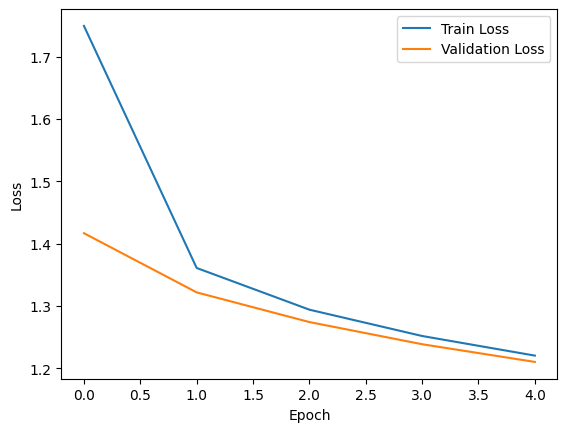

/tmp/ipykernel_1518753/2938726709.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(tokenizer.encode(inputs)).unsqueeze(0)


I could pick my lanceond the world with the world,
And then the common of the people,
And then the common of the people,



In [12]:
train_dataloader, val_dataloader = create_dataloader("input.txt", tokenizer, chunk_size=50, batch_size=512)
model = SparseMoETransformer(
    vocab_size=len(tokenizer.char2index),
    seq_len=50,
    embed_size=64,
    n_layers=3,
    n_heads=8,
    num_experts=8,
    active_experts=2,
).to(device)


# 训练模型
def run(model, train_dataloader, valid_dataloader, device, epochs=10):
    train_losses = [] # FIXME:
    valid_losses = [] # FIXME:

    for epoch in range(epochs):
        train_loss = train(model, train_dataloader, epoch, device)
        valid_loss = validate(model, valid_dataloader, epoch, device)
        train_losses.append(train_loss) # FIXME:
        valid_losses.append(valid_loss) # FIXME:
        print(f"Epoch {epoch} Train Loss: {train_loss}, Valid Loss: {valid_loss}")

    return train_losses, valid_losses


# FIXME: 用 matplotlib plot 训练过程中的 loss 变化
# run(model, dataloader, None, device, epochs=5)
train_losses, valid_losses = run(model, train_dataloader, val_dataloader, device, epochs=5)
# Plot the training and validation loss
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 保存模型
torch.save(model.state_dict(), "model.pth")
model.load_state_dict(torch.load("model.pth"))
print(
    tokenizer.decode(
        model.generate("I could pick my lance", max_new_tokens=100)[0]
    )
)

In [14]:
model.load_state_dict(torch.load("model.pth"))
print(
    tokenizer.decode(
        model.generate("A strange one as ever", max_new_tokens=100)[0]
    )
)

/tmp/ipykernel_1518753/2938726709.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(tokenizer.encode(inputs)).unsqueeze(0)


A strange one as everome time
The stret-place of the prince of the people,
And then the common of the prince of the peopl
